# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
from functools import reduce

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, Normalizer
from pyspark.mllib.evaluation import MulticlassMetrics

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/02 11:54:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load the file
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [4]:
print("Shape:", (df.count(), len(df.columns)))

Shape: (286500, 18)


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
def count_missing(df, col):
    """
    A helper function which count how many missing values in a colum of the dataset.
    
    This function is useful because the data can be either three cases below:
    
    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392


24/06/02 11:54:27 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


userAgent: 8346
userId: 8346


# Data Preprocessing

Due to the fact that, the churn prediction is user-based behavior. As a result, rows without userID or seesionID is kind of useless to the prediction, we decide to remove these rows from the dataset.

In [8]:
#remove null & empty data of userId & sessionId
df_filter = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_filter = df.filter(df['userId']!='')

In [9]:
#Checking the result of removal
print("[missing values]\n")
for col in df_filter.columns:
    missing_count_df_filter = count_missing(df_filter, col)
    if missing_count_df_filter > 0:
        print("{}: {}".format(col, missing_count_df_filter))

[missing values]

artist: 50046
length: 50046
song: 50046


In [10]:
#Drop duplicated
print(f'Duplicate rows: {df_filter.count() - df_filter.dropDuplicates().count()}')

Duplicate rows: 0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
#create column "Downgrade"
df_filter = df_filter.withColumn("Downgrade", F.when(F.col("page") == "Submit Downgrade", 1).otherwise(0))

In [12]:
#create column "Churn"
df_filter = df_filter.withColumn("Churn", F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0))

In [13]:
#Define window bounds for downgrade 
window_downgrade = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_filter = df_filter.withColumn("total_downgrade", F.sum("Downgrade").over(window_downgrade))
#Define window bounds for churn
window_churn = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_filter = df_filter.withColumn("total_churn", F.sum("Churn").over(window_churn))

In [14]:
df_filter.filter(F.col("Churn") == 1).sort("total_churn", ascending=False).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,Downgrade,Churn,total_downgrade,total_churn
0,None,Cancelled,Rodrigo,M,73,Carey,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,...,185,None,200,1542740649000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100014,0,1,0,1
1,None,Cancelled,Rayden,M,185,Phillips,NaN,free,"Dallas-Fort Worth-Arlington, TX",GET,...,172,None,200,1543143782000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100021,0,1,0,1
2,None,Cancelled,Alex,M,145,Hogan,NaN,paid,"Denver-Aurora-Lakewood, CO",GET,...,842,None,200,1539729037000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101,0,1,0,1
3,None,Cancelled,Mason,M,10,Hart,NaN,free,"Corpus Christi, TX",GET,...,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,0,1,0,1
4,None,Cancelled,Kaleb,M,49,Thompson,NaN,paid,"Los Angeles-Long Beach-Anaheim, CA",GET,...,1864,None,200,1542181031000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",29,0,1,0,1
5,None,Cancelled,Ethan,M,176,Johnson,NaN,paid,"Lexington-Fayette, KY",GET,...,934,None,200,1539761972000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",51,0,1,0,1
6,None,Cancelled,Alexi,F,42,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,...,1819,None,200,1542051608000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,0,1,1,1
7,None,Cancelled,Mahi,F,17,Robinson,NaN,free,"Houston-The Woodlands-Sugar Land, TX",GET,...,191,None,200,1542038645000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,100022,0,1,0,1
8,None,Cancelled,Teagan,F,306,Roberts,NaN,paid,"New Philadelphia-Dover, OH",GET,...,1519,None,200,1541463632000,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,28,0,1,0,1
9,None,Cancelled,Jeffery,M,46,Wheeler,NaN,paid,"Bozeman, MT",GET,...,1324,None,200,1540875543000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",3,0,1,0,1


In [15]:
df_filter.groupBy("Churn").count().show()
df_filter.groupBy("Downgrade").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+

+---------+------+
|Downgrade| count|
+---------+------+
|        1|    63|
|        0|278091|
+---------+------+



In [16]:
# Number of interactions users 
df_filter.dropDuplicates(['userId']).groupby(['total_churn']).count().sort("total_churn").show()

+-----------+-----+
|total_churn|count|
+-----------+-----+
|          0|  173|
|          1|   52|
+-----------+-----+



In [89]:
#Calculate churn rate 
churned_user_count = df_filter.filter(df_filter["Churn"] == 1).select("userId").dropDuplicates().count()
print("churned user count: {} (total: {})".format(churned_user_count, df_filter.dropDuplicates(['userId']).count()))
print("churned user rate: {:.2f}%".format(churned_user_count / df_filter.dropDuplicates(['userId']).count() * 100))

churned user count: 52 (total: 225)
churned user rate: 23.11%


In [18]:
sex = df_filter.select("userId", 'gender', 'Churn').distinct()
sex.show()

+------+------+-----+
|userId|gender|Churn|
+------+------+-----+
|   111|     F|    0|
|    11|     F|    0|
|    32|     M|    0|
|   150|     M|    0|
|   148|     M|    0|
|   115|     F|    0|
|    93|     M|    0|
|   140|     F|    0|
|   147|     M|    0|
|   110|     M|    0|
|    44|     F|    0|
|   124|     F|    0|
|    45|     F|    0|
|   106|     F|    0|
|    19|     F|    0|
|    82|     F|    0|
|    42|     F|    0|
|   105|     M|    0|
|   132|     F|    0|
|    76|     M|    0|
+------+------+-----+
only showing top 20 rows



In [19]:
df_sex = sex.groupby(['Churn', 'gender']).count().sort('Churn').toPandas()

In [20]:
df_sex.head()

,Churn,gender,count
0,0,M,121
1,0,F,104
2,1,F,20
3,1,M,32


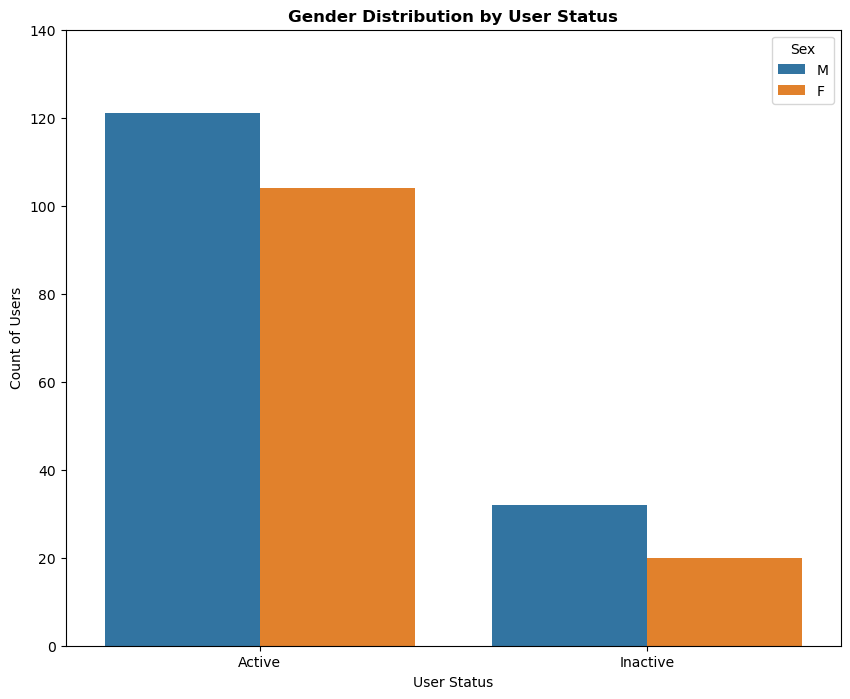

In [21]:
#Sex distribution by user status
fig, ax = plt.subplots(figsize = (10,8));
sns.barplot(data=df_sex, x='Churn', y='count', hue='gender');
plt.ylim([0,140]);
plt.title("Gender Distribution by User Status", fontweight='bold');
plt.xlabel("User Status");
plt.ylabel("Count of Users");
plt.xticks(np.arange(len(['Active', 'Inactive'])), ['Active', 'Inactive'])
plt.legend(title='Sex');

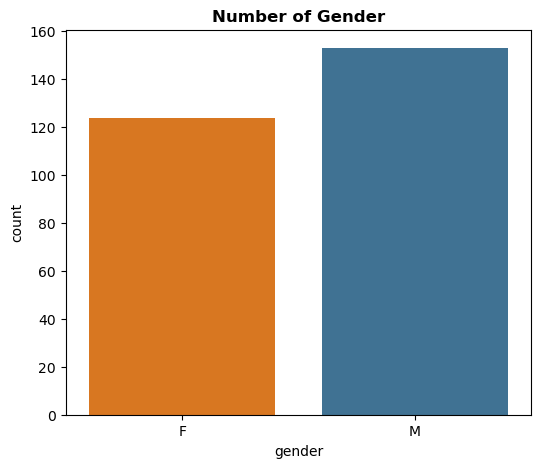

In [22]:
fig, ax = plt.subplots(figsize = (6,5), dpi = 100);
df_sex_count = sex.select('gender').toPandas()
ax = sns.countplot(x='gender', data=df_sex_count, palette=["#f77502", "#3275a1"])
plt.title("Number of Gender", fontweight='bold');

In [23]:
level = df_filter.select('userId', 'level', 'Churn').distinct()
df_level = level.groupby(['Churn', 'level']).count().sort('Churn').toPandas()

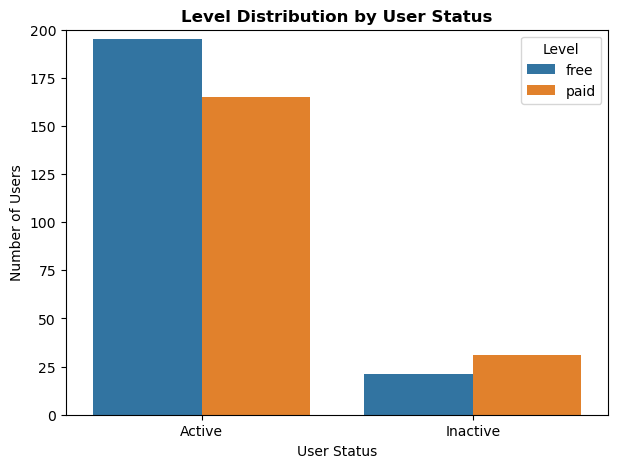

In [24]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100);
sns.barplot(data=df_level, x='Churn', y='count', hue='level');
plt.ylim([0,200]);
plt.title("Level Distribution by User Status", fontweight='bold');
plt.xlabel("User Status");
plt.ylabel("Number of Users");
plt.xticks(np.arange(len(['Active', 'Inactive'])), ['Active', 'Inactive'])
plt.legend(title='Level');

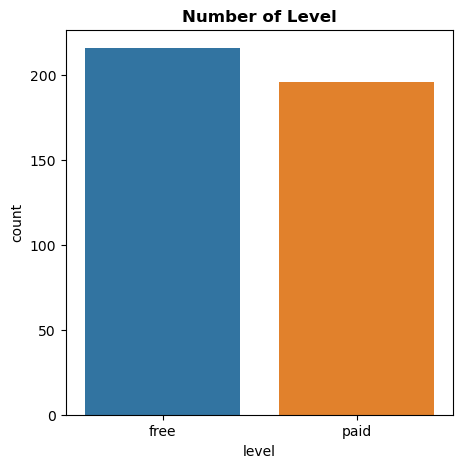

In [25]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 100);
df_level_count = level.select('level').toPandas()
ax = sns.countplot(x='level', data=df_level_count)
plt.title("Number of Level", fontweight='bold');

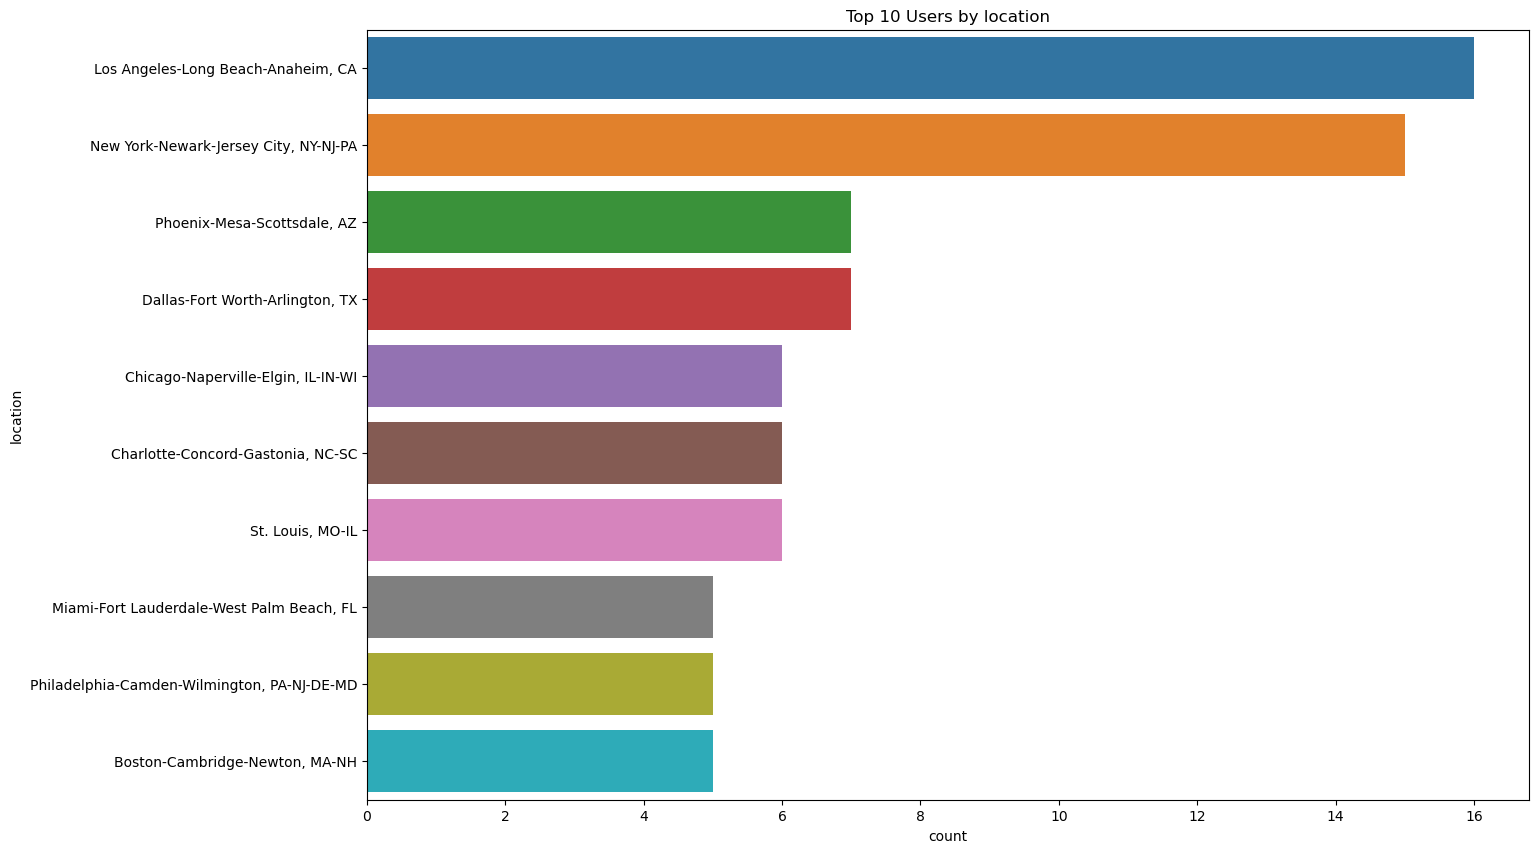

In [26]:
# Count users by location
df_user_location = df_filter.select('userId', 'location').dropDuplicates().toPandas()

fig, ax = plt.subplots(figsize = (15,10), dpi = 100);
data_order = df_user_location['location'].value_counts().index[:10]
sns.countplot(data = df_user_location, y = 'location', order = data_order).set_title('Top 10 Users by location')
plt.show()

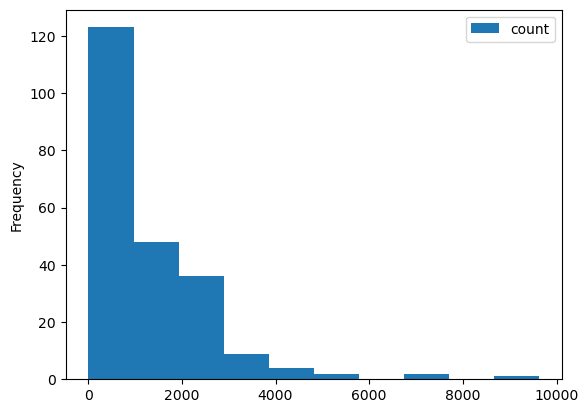

In [27]:
#Logs per user distribution
df_user_logs = df_filter.groupby('userId').count().toPandas()

df_user_logs.plot(kind='hist');

In [28]:
# Logs per user statistics
df_user_logs.describe()

,count
count,225.000000
mean,1236.240000
std,1329.531716
min,6.000000
25%,296.000000
50%,848.000000
75%,1863.000000
max,9632.000000


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
# Select relevant features
user_features_df = df_filter.select('userId', 'level', 'gender', 'Churn', 'ts', 'length', 'artist', 'song', 'page')

# Map gender to 0 and 1
user_features_df = user_features_df.withColumn('gender_mapped', F.when(F.col('gender') == 'M', 0).when(F.col('gender') == 'F', 1))

# Group by userId and enriching more feautres
user_statistics_df = user_features_df.groupBy('userId').agg(
    F.avg('length').alias('avg_song_length'),
    F.countDistinct('artist').alias('total_artist'),
    F.countDistinct('song').alias('total_song'),
    F.count('page').alias('total_session'),
    F.sum(F.when(F.col('page') == 'Thumbs Up', 1).otherwise(0)).alias('total_thumb_up'),
    F.sum(F.when(F.col('page') == 'Thumbs Down', 1).otherwise(0)).alias('total_thumb_down'),
    F.sum(F.when(F.col('page') == 'Add Friend', 1).otherwise(0)).alias('total_add_friend'),
    F.sum(F.when(F.col('page') == 'Add to Playlist', 1).otherwise(0)).alias('total_add_playlist'),
    F.first('gender_mapped').alias('gender')
)

In [30]:
user_statistics_df.toPandas().head(5)

,userId,avg_song_length,total_artist,total_song,total_session,total_thumb_up,total_thumb_down,total_add_friend,total_add_playlist,gender
0,100010,243.421445,252,269,381,17,5,4,7,1
1,200002,242.916992,339,378,474,21,6,4,8,0
2,125,261.139138,8,8,11,0,0,0,0,0
3,124,248.176537,2232,3339,4825,171,41,74,118,1
4,51,247.880551,1385,1854,2464,100,21,28,52,0


In [31]:
target = df_filter.select('userId', F.col('total_churn').alias('target')).dropDuplicates()

In [32]:
modeling = user_statistics_df.join(target, "userId").drop("userId")
modeling = modeling.dropna()

In [33]:
modeling_df = modeling.toPandas()

In [34]:
modeling_df.head()

,avg_song_length,total_artist,total_song,total_session,total_thumb_up,total_thumb_down,total_add_friend,total_add_playlist,gender,target
0,243.421445,252,269,381,17,5,4,7,1,0
1,242.916992,339,378,474,21,6,4,8,0,0
2,261.139138,8,8,11,0,0,0,0,0,1
3,248.176537,2232,3339,4825,171,41,74,118,1,0
4,247.880551,1385,1854,2464,100,21,28,52,0,1


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
feature_col = modeling.columns
feature_col.remove("target")
# split the data to 70% training and 30% testing, set random seed to 42.
train, test = modeling.randomSplit([0.7, 0.3], seed=42)

In [36]:
def build_predict_model(classifier, param):
    """
    Build a classification model with Cross Validation.

    Parameters:
    classifier: Model
        The classification model to be used.
    param: dict
        Parameters for tuning the model.
    feature_columns: list
        List of feature columns.

    Returns:
    model
        The classification model.
    """
    # Create a vector for the features
    assembler = VectorAssembler(inputCols=feature_col, outputCol="features_vec")
    
    # Normalize the vectors
    scaler = Normalizer(inputCol="features_vec", outputCol="features")
    
    # Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Create a CrossValidator with 3 folds
    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
        numFolds=3,
    )
    
    return model

In [37]:
def evaluate_predict_model(predictions):
    """
    Evaluate a classification model using the F1 score metric.

    Parameters:
    predictions: DataFrame
        DataFrame containing model predictions.

    Returns:
    None
    """
    # Create a MulticlassClassificationEvaluator for F1 score
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target")
    
    # Calculate and print the F1 score
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    acc = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})
    print('F1 score: {}'.format(f1_score))
    print('Accuracy: {}'.format(acc))    

## LogistircRegression Model

In [38]:
lr = LogisticRegression(featuresCol="features", labelCol="target")
lr_param = ParamGridBuilder().build()
lr_model = build_predict_model(lr, lr_param)

In [39]:
lr_fit_model = lr_model.fit(train)
pred = lr_fit_model.transform(test)

24/06/02 11:54:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/02 11:54:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [40]:
evaluate_predict_model(pred)

F1 score: 0.5854177448105342
Accuracy: 0.6774193548387096


## RandomForest Model

In [41]:
rf = RandomForestClassifier(featuresCol="features", labelCol="target")
rf_param = ParamGridBuilder().build()
rf_model = build_predict_model(rf, rf_param)

In [42]:
rf_fit_model = rf_model.fit(train)
pred_rf = rf_fit_model.transform(test)

In [43]:
evaluate_predict_model(pred_rf)

F1 score: 0.6268759703294807
Accuracy: 0.7096774193548387


## Gradient Boosting Model

In [44]:
gb = GBTClassifier(featuresCol="features", labelCol="target")
gb_param = ParamGridBuilder().build()
gb_model = build_predict_model(gb, gb_param)

In [45]:
gb_fit_model = gb_model.fit(train)
pred_gb = gb_fit_model.transform(test)

In [46]:
evaluate_predict_model(pred_gb)

F1 score: 0.670482136663198
Accuracy: 0.6935483870967742


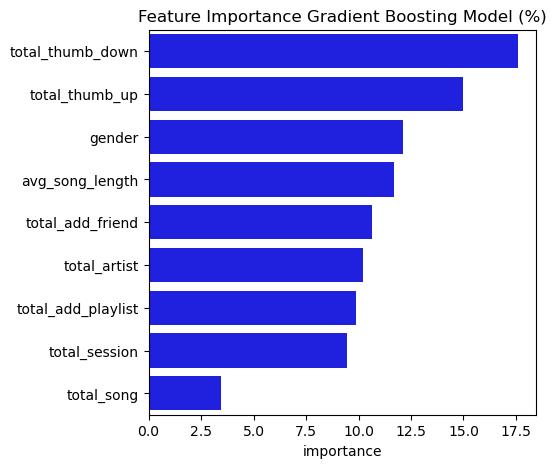

In [83]:
gb_df = pd.DataFrame()
gb_df['feature'] = feature_col
gb_df['importance'] = gb_fit_model.bestModel.stages[2].featureImportances.values.tolist()
gb_df['importance'] = gb_df['importance']*100
gb_df = gb_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(5,5))
sns.barplot(x='importance', y='feature', data=gb_df, color="blue")
plt.title('Feature Importance Gradient Boosting Model (%)')
plt.ylabel('');

## Hyper tunning

In [59]:
# Define a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth,[5, 10]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.minInstancesPerNode, [1, 10]) \
    .addGrid(rf.subsamplingRate, [0.7, 1.0]) \
    .build()


model_tuned_rf = build_predict_model(rf, paramGrid)

In [60]:
rf_fit_tunned_model = model_tuned_rf.fit(train)

In [66]:
best_model = rf_fit_tunned_model.bestModel

In [68]:
best_model_pred = best_model.transform(test)

In [69]:
evaluate_predict_model(best_model_pred)

F1 score: 0.6163748212128366
Accuracy: 0.6935483870967742


In [63]:
best_model_pred.show(5)

+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+------+------+--------------------+--------------------+--------------------+--------------------+----------+
|   avg_song_length|total_artist|total_song|total_session|total_thumb_up|total_thumb_down|total_add_friend|total_add_playlist|gender|target|        features_vec|            features|       rawPrediction|         probability|prediction|
+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+------+------+--------------------+--------------------+--------------------+--------------------+----------+
|230.82630793478256|          89|        90|          112|             3|               2|               0|                 0|     0|     0|[230.826307934782...|[0.80677542249019...|[33.6574074074074...|[0.67314814814814...|       0.0|
| 234.8357531764706|          82|        85|          11

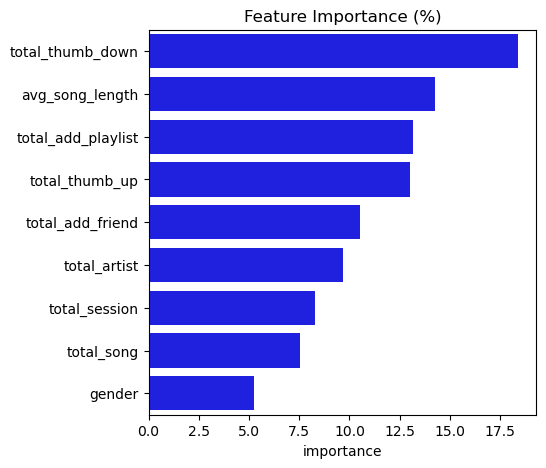

In [82]:
pred_tunned_df = pd.DataFrame()
pred_tunned_df['feature'] = feature_col
pred_tunned_df['importance'] = rf_fit_tunned_model.bestModel.stages[2].featureImportances.values.tolist()
pred_tunned_df = pred_tunned_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
pred_tunned_df['importance'] = pred_tunned_df['importance']*100

plt.figure(figsize=(5,5))
sns.barplot(x='importance', y='feature', data=pred_tunned_df, color="blue")
plt.title('Feature Importance tunned RandomForest (%)')
plt.ylabel('');

In [84]:

# Create a dictionary with model performance metrics
model_performance = {
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting", "Random Forest Tuned"],
    "F1 Score": [0.5854177448105342, 0.6268759703294807, 0.670482136663198, 0.6163748212128366],
    "Accuracy": [0.6774193548387096, 0.7096774193548387, 0.6935483870967742, 0.6935483870967742]
}

# Convert dictionary to DataFrame
df_performance = pd.DataFrame(model_performance)

# Round the values to 2 decimal places
df_performance["Accuracy"] = (df_performance["Accuracy"] * 100).round(2).astype(str) + '%'
df_performance["F1 Score"] = (df_performance["F1 Score"] * 100).round(2).astype(str) + '%'

df_performance


,Model,F1 Score,Accuracy
0,Logistic Regression,58.54%,67.74%
1,Random Forest,62.69%,70.97%
2,Gradient Boosting,67.05%,69.35%
3,Random Forest Tuned,61.64%,69.35%


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.